# Tipos de dados não-atômicos

---

Atenção, este Notebook faz uso do comando `DROP DATABASE` para recriar um Database nomeado `censo2022`.

---

## Autores

| Nome | nUSP |
| :--- | :--- |
| Guilherme de Abreu Barreto | 12543033 |
| Lucas Eduardo Gulka Pulcinelli | 12547336 |
| Vinicio Yusuke Hayashibara | 13642797 |

## Enunciado

Questões:

1. Quais são as 10 cidades com população maior do que 100 mil habitantes mais próximas de 'São Carlos, SP', considerando a distância Manhattan e
    1. A distribuição só de Mulheres,
    2. A distribuição só de Homens,
    3. Só a distribuição total.

Para isso:
- Crie uma nova tabela que tenha como atributos:
    - a identificação da cidade como uma tupla com o Nome e a UF da Cidade, e
    - um atributo bidimensional com as contagens de homens, mulheres e população total para cada cor dos habitantes.
- Calcule enumeradores adequados para as dimensões do atributo multidimensional criado.
- Acrescente à essa tabela um atributo bidimensional com as proporções de cada valor de Cor/Sexo
- Execute as consultas solicitadas

## Resolução

Para resolvermos este exercício e tendo em vista a reutilização do banco de dados para tarefas futuras, em vez de seguirmos as orientações propostas e criarmos uma nova tabela com atribudos bidimencionais para trabalhar o atual exercício, optamos por criar as tabelas principais já com estes atributos bidimencionais para descrever aspectos demográficos da população. Os detalhes desta implementação encontram-se descritos à seguir.

### Configuração

Na seguinte célula se descrevem constantes pertinentes ao acesso ao banco de dados e a localização dos arquivos de referência que nos foram enviados pelo Tidia. Para adequada reprodução, recomenda-se a alteração destes valores para valores correspondentes ao ambiente de execução sendo utilizado

In [1]:
DEFAULT_DATABASE = "postgres"
CENSO_DATABASE = "censo2022"
USER = "postgres"
PASSWORD = "postgres"
HOST = "localhost"
PORT = 5432
URI = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}/"
FILES = {
    'states': {
        'filepath_or_buffer': 'datasets/BREstados.csv',
    },
    'cities': {
        'filepath_or_buffer': 'datasets/TabelaMunicipios.csv',
    },
    'households': {
        'filepath_or_buffer': 'datasets/tabela9923.csv',
    },
    'race': {
        'filepath_or_buffer': 'datasets/tabela9606.csv',
        'sep': ';',
        'header': None,
        'skiprows': 1,
    },
    'education': {
        'filepath_or_buffer': 'datasets/tabela10065.csv',
        'header': None,
        'skiprows': 1,
    },
}

In [1]:
import colorsys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import re
from enum import Enum
from dataclasses import dataclass, fields
from math import sqrt
from matplotlib.patches import Patch
from sqlalchemy import (
    Float,
    Integer,
    Index,
    String,
    Text,
    CheckConstraint as constraint,
    UniqueConstraint as unique,
    PrimaryKeyConstraint as pkc,
    ForeignKeyConstraint as fkc,
    ForeignKey as fk,
    and_,
    cast,
    create_engine,
    insert,
    text,
    func,
    select,
    literal
)
from sqlalchemy.orm import (
    Mapped,
    Session,
    composite,
    declarative_base,
    declared_attr,
    relationship,
    sessionmaker,
    mapped_column as column,
    validates
)
from sqlalchemy.dialects.postgresql import JSONB
from sqlalchemy.ext.hybrid import hybrid_method, hybrid_property
from sqlalchemy.sql.schema import CheckConstraint
from sqlalchemy.orm.descriptor_props import Composite
from typing import Optional, Any

### Criação ou Recriação do Banco de dados

Conforme aviso prévio, na seguinte céula é exluido um database `censo2022`, se este houver, para reprodução do experimento desde seu início.

In [3]:
engine = create_engine(URI + DEFAULT_DATABASE, echo=True)

with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
    terminate_sql = text(f"""
        SELECT pg_terminate_backend(pid)
        FROM pg_stat_activity
        WHERE datname = '{CENSO_DATABASE}';
    """)
    try:
        conn.execute(terminate_sql)
    except ProgrammingError as e:
        print(f"Could not terminate connections (this is often normal): {e}")
    conn.execute(text(f"DROP DATABASE IF EXISTS {CENSO_DATABASE};"))
    conn.execute(text(f"CREATE DATABASE {CENSO_DATABASE};")) 
    

2025-09-25 09:40:45,139 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-09-25 09:40:45,140 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-25 09:40:45,145 INFO sqlalchemy.engine.Engine select current_schema()
2025-09-25 09:40:45,149 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-25 09:40:45,152 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-09-25 09:40:45,153 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-25 09:40:45,157 INFO sqlalchemy.engine.Engine BEGIN (implicit; DBAPI should not BEGIN due to autocommit mode)
2025-09-25 09:40:45,158 INFO sqlalchemy.engine.Engine 
        SELECT pg_terminate_backend(pid)
        FROM pg_stat_activity
        WHERE datname = 'censo2022';
    
2025-09-25 09:40:45,159 INFO sqlalchemy.engine.Engine [generated in 0.00297s] {}
2025-09-25 09:40:45,165 INFO sqlalchemy.engine.Engine DROP DATABASE IF EXISTS censo2022;
2025-09-25 09:40:45,166 INFO sqlalchemy.engine.Engine [generated in 0.00086s] {}
2025-09-25 09:4

### Definição de funções auxiliares

In [4]:
def backref(back_populates: str) -> Mapped[Any]:
    return relationship(back_populates=back_populates)


def childOf(back_populates: str) -> Mapped[Any]:
    return relationship(
        back_populates=back_populates,
        cascade="all, delete-orphan",
    )

def digits(name:str) -> CheckConstraint:
    return constraint("id ~ '^[0-9]+$'", name=name)

In [5]:
Base = declarative_base()

### Definição de tipos compostos

Abaixo descrevemos alguns atributos os quais implementamos como sendo tipos compostos. Isto é, estes são lidos enquanto _tuplas_.

#### Domicílios (_Households_)

Descreve a quantidade de domicílios em ambiente urbano e rural, respectivamente, _em uma dada cidade_. Acompanha método para cálculo do total de domicílios contabilizados.

In [6]:
class Households:
    __abstract__: bool = True

    @dataclass
    class Count:
        urban: int | None
        rural: int | None

    @declared_attr
    def households(cls) -> Mapped[Count]:
        columns = []
        for f in fields(cls.Count):
            columns.append(
                column(
                    f.name,
                    constraint(
                        f"{f.name} >= 0",
                        name=f"ck_{cls.__tablename__}_{f.name}_positive"
                    ),
                    comment=f"Total households in {f.name} areas.")
            )
        return composite(*columns)

    @hybrid_property
    def total_households(self):
        """Python-side property for total households."""
        return self.urban + self.rural

    @total_households.expression
    def total_households(cls):
        """SQL-side expression for querying total households."""
        return cls.urban + cls.rural

#### Biomas (Biomes)

Descreve a distribuição de Biomas presente, em números percentuais, em um dado estado. Corresponde a tupla (Amazônia, Mata Atlântica, Caatinda, Cerrado, Pantanal, Pampas). Acompanha métodos para verificação das quantidades descritas.

In [7]:
class Biomes(Base):
    __abstract__: bool = True

    @dataclass
    class Distribution:
        """A dataclass to represent the distribution of Brazilian biomes."""
        amazon_rainforest: float = 0.0
        atlantic_forest: float = 0.0
        caatinga: float = 0.0
        cerrado: float = 0.0
        pantanal: float = 0.0
        pampas: float = 0.0

    @declared_attr
    def biomes_distribution(cls) -> Mapped[Distribution]:
        columns = []
        for f in fields(cls.Distribution):
            columns.append(
                column(
                    f.name,
                    constraint(
                        f"{f.name} BETWEEN 0 AND 100",
                        name=f"ck_{cls.__tablename__}_{f.name}_range",
                    ),
                    comment=f"Percentage of the territory covered by the {f.name} biome",
                )
            )
        return composite(*columns)

#### Localização (_Location_)

Afere uma localidade pelas suas coordeandas de longitude e latitude. Acompanha método para cálculo de distância entre pares de coordenadas.

In [8]:
class Location(Base):
    __abstract__: bool = True

    @dataclass
    class Coordinates:
        longitude: float
        latitude: float

    @declared_attr
    def coordinates(cls) -> Mapped[Coordinates]:
        lon = column(
            "longitude",
            constraint(
                'longitude >= -180 AND longitude <= 180',
                name=f'ck_{cls.__tablename__}_longitude_range',
            ),
        )
        lat = column(
            "latitude",
            constraint(
                'latitude >= -90 AND latitude <= 90',
                name=f'ck_{cls.__tablename__}_latitude_range',
            ),
        )
        return composite(lon, lat)

    @hybrid_method
    def distance(
        self,
        other: "Coordinates",
        metric: str = 'euclidean'
    ) -> float:
        """
        Calculate distance to another coordinate.
        
        Args:
            other: Coordinate instance
            metric: 'euclidean' or 'manhattan'
        
        Returns:
            Distance between coordinates
        """
        x = self.coordinates.longitude - other.longitude
        y = self.coordinates.latitude - other.latitude
        match metric:
            case 'euclidean':
                return sqrt(x**2 + y**2)
            case 'manhattan':
                return abs(x) + abs(y)
            case _:
                raise ValueError(
                    "Metric must be 'euclidean' or 'manhattan'"
                )

    @distance.expression
    def distance(
        cls,
        other: "Coodinates",
        metric: str = 'euclidean'
    ):
        x = cls.longitude - other.longitude
        y = cls.latitude - other.latitude
        
        match metric:
            case 'euclidean':
                return func.sqrt(x * x + y * y)
            case 'manhattan':
                return func.abs(x) + func.abs(y)
            case _:
                raise ValueError(
                    "Metric must be 'euclidean' or 'manhattan'"
                )

### Definição e criação das tabelas

Seguimos a declaração das tabelas e suas propriedades. O seguinte diagrama, criado com o software DBeaver, ilustra o resultado da nossa modelagem.

![Modelagem do banco de dados Censo 2022](imgs/modelagem.png)

#### Regiões (_Regions_)

Descreve agrupamentos de estados da federação. À saber, as regiões _Norte, Nordeste, Sudeste, Sul_ e _Centro-Oeste_.

In [9]:
class Region(Base):
    __tablename__: str = "regions"

    # Attributes
    id: Mapped[str] = column(
        String(1), digits("ck_region_id"), primary_key=True
    )
    name: Mapped[str] = column(unique=True)

    # Relationships
    states: Mapped[list["State"]] = childOf('region')

#### Estados (States)

Descreve unidades da federação e a distribuição de biomas visto nestes.

In [10]:
class State(Location, Biomes):
    __tablename__: str = "states"

    # Attributes
    id: Mapped[str] = column(String(1), digits("ck_state_id"))
    name: Mapped[str] = column(unique=True)
    uf: Mapped[str] = column(String(2), unique=True)
    area: Mapped[float]

    # Foreign keys
    region_id: Mapped[str] = column(fk("regions.id"))

    # Relationships
    region: Mapped["Region"] = backref("states")
    cities: Mapped[list["City"]] = childOf("state")

    __table_args__ = (
        pkc("region_id", "id"),
        unique('longitude', 'latitude', name='uq_state_location'),
    )

### Cidades (_Cities_)

Identifica municípios, além de dados acerca dos domicílios e a população locais. Para aninhar informações nos dados demográficos, fizemos uso do tipo de dado estruturado JSON para identificar grupos étnicos e diferentes formações de ensino superior e, para cada uma destas categorias, descrever o número de homens e mulheres que se identificaram com cada uma destas.

Outras características notáveis para esta tabela são:
- Capitais são indexadas para rápido acesso em consultas
- Um método associado a tabela gera um código IBGE único para cada cidade que é uma concatenação dos códigos utilizados para identificar a região, o estado, e finalmente a cidade.

In [11]:
class City(Location, Households):
    __tablename__: str = "cities"

    # Attributes
    id: Mapped[str] = column(String(5), digits("ck_city_id"))
    name: Mapped[str]
    is_capital: Mapped[bool] = column(default=False, server_default='false')
    ddd: Mapped[str] = column(String(2), digits("ck_city_ddd"))
    population: Mapped[dict] = column(
        JSONB,
        comment="A document to store various demographic data on the city inhabitants" 
    )
    
    # Foreign keys
    timezone_name: Mapped[str] = column(fk("timezones.name"))
    region_id: Mapped[str]
    state_id: Mapped[str]

    # Relationships
    timezone: Mapped["Timezone"] = backref("cities")
    state: Mapped["State"] = backref("cities")

    @hybrid_property
    def ibge_code(self) -> str:
        """Python-side property to get the IBGE code."""
        return self.region_id + self.state_id + self.id

    @ibge_code.expression
    def ibge_code(cls):
        """SQL-side expression for querying."""
        return func.concat(
            cast(cls.region_id, String),
            cast(cls.state_id, String),
            cast(cls.id, String)
        )

    @hybrid_property
    def inhabitants(self) -> int:
        """
        Calculates the total number of inhabitants from the 'race'
        distribution in the population JSON. Works on a loaded Python object.
        """
        race_data = self.population.get('race', {})
        total = 0

        # Sum the male and female counts for each race category
        for gender_counts in race_data.values():
            total += gender_counts.get('male', 0) + gender_counts.get('female', 0)
        return total

    @inhabitants.expression
    def inhabitants(cls):
        """
        Creates a PostgreSQL-specific SQL expression to calculate the total
        inhabitants directly in the database.
        """
        # Create an alias for the key-value pairs expanded from the JSON
        race_elements = func.jsonb_each(
            cls.population['race']
        ).table_valued(
            column("key", Text),
            column("value", JSONB)
        ).alias("race_elements")

        # Build a subquery that sums the male and female values from
        # the expanded JSON elements.
        subquery = (
            select(
                func.sum(
                    # Safely cast the text values to Integer, defaulting to 0 if null
                    func.coalesce(race_elements.c.value.op('->>')('male').cast(Integer), 0) +
                    func.coalesce(race_elements.c.value.op('->>')('female').cast(Integer), 0)
                )
            )
            .select_from(race_elements)
            .scalar_subquery()
        )
        
        # Wrap the entire subquery in COALESCE to handle cases where the
        # 'race' key or the population column itself is NULL.
        return func.coalesce(subquery, 0)

    __table_args__ = (
        pkc("region_id", "state_id", "id"),
        fkc(
            ['region_id', 'state_id'],
            ['states.region_id', 'states.id'],
            name='fk_region_composite'
        ),
        Index(
            'state_capitals_index',
            'region_id', 'state_id',
            postgresql_where=text('is_capital'),
            unique=True,
        ),
        unique("longitude", "latitude", name="uq_city_location"),
    )

#### Fuso Horário (_Timezone_)

Lista de fuso horários e a diferença entre cada um destes com o horário em Greenwich.

In [12]:
class Timezone(Base):
    __tablename__: str = "timezones"

    # Attributes
    name: Mapped[str] = column(primary_key=True)
    utc_offset: Mapped[int]

    # Relationships
    cities: Mapped[list["City"]] = backref('timezone')

In [13]:
#### Criação das tabelas

In [14]:
engine = create_engine(URI + CENSO_DATABASE, echo=True)
Session = sessionmaker(bind=engine)
Base.metadata.create_all(engine)

2025-09-25 09:40:45,432 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-09-25 09:40:45,433 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-25 09:40:45,435 INFO sqlalchemy.engine.Engine select current_schema()
2025-09-25 09:40:45,436 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-25 09:40:45,438 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-09-25 09:40:45,440 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-09-25 09:40:45,442 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-25 09:40:45,453 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

### População das tabelas

#### Regiões e Fuso horário

In [15]:
# 1. Region Data
regions_data = ["Norte", "Nordeste", "Sudeste", "Sul", "Centro-Oeste"]

# 2. Timezone Data
timezones_data = [
    ('America/Noronha', -2),
    ('America/Sao_Paulo', -3),
    ('America/Brasilia', -3),
    ('America/Recife', -3),
    ('America/Porto_Velho', -4),
    ('America/Manaus', -4),
    ('America/Rio_Branco', -5),
]

with Session() as session:
    # Populate the Regions table
    regions = [
        Region(id=str(idx), name=name) for idx, name in enumerate(regions_data, start=1)
    ]
    session.add_all(regions)

    # Populate the Timezones table
    timezones = [Timezone(name=name, utc_offset=offset) for name, offset in timezones_data]
    session.add_all(timezones)

    # Commit the changes to the database
    session.commit()

2025-09-25 09:40:45,703 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-25 09:40:45,708 INFO sqlalchemy.engine.Engine INSERT INTO regions (id, name) VALUES (%(id__0)s, %(name__0)s), (%(id__1)s, %(name__1)s), (%(id__2)s, %(name__2)s), (%(id__3)s, %(name__3)s), (%(id__4)s, %(name__4)s)
2025-09-25 09:40:45,710 INFO sqlalchemy.engine.Engine [generated in 0.00160s (insertmanyvalues) 1/1 (unordered)] {'name__0': 'Norte', 'id__0': '1', 'name__1': 'Nordeste', 'id__1': '2', 'name__2': 'Sudeste', 'id__2': '3', 'name__3': 'Sul', 'id__3': '4', 'name__4': 'Centro-Oeste', 'id__4': '5'}
2025-09-25 09:40:45,715 INFO sqlalchemy.engine.Engine INSERT INTO timezones (name, utc_offset) VALUES (%(name__0)s, %(utc_offset__0)s), (%(name__1)s, %(utc_offset__1)s), (%(name__2)s, %(utc_offset__2)s), (%(name__3)s, %(utc_offset__3)s), (%(name__4)s, %(utc_offset__4)s), (%(name__5)s, %(utc_offset__5)s), (%(name__6)s, %(utc_offset__6)s)
2025-09-25 09:40:45,716 INFO sqlalchemy.engine.Engine [generated in 0.00013

#### Estados

In [16]:
df = pd.read_csv(**FILES['states'])
df.fillna(0.0, inplace=True)

states_to_insert = []
for _, row in df.iterrows():
    code_str = str(row['codigouf'])
    state_data = {
        'region_id': code_str[0],
        'id': code_str[1],
        'uf': row['uf'],
        'name': row['estado'],
        'longitude': row['long'],
        'latitude': row['lat'],
        'area': row['Area'],
        'amazon_rainforest': row['Amazônia'],
        'atlantic_forest': row ['Mata Atlântica'],
        'caatinga': row ['Caatinga'],
        'cerrado': row['Cerrado'],
        'pantanal': row['Pantanal'],
        'pampas': row['Pampa']
    }

    states_to_insert.append(state_data)


with Session() as session:
    session.bulk_insert_mappings(State, states_to_insert)
    session.commit()

2025-09-25 09:40:45,740 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-25 09:40:45,746 INFO sqlalchemy.engine.Engine INSERT INTO states (id, name, uf, area, region_id, longitude, latitude, amazon_rainforest, atlantic_forest, caatinga, cerrado, pantanal, pampas) VALUES (%(id__0)s, %(name__0)s, %(uf__0)s, %(area__0)s, %(region_id__0)s, %(longitude__0)s, %(latitude__0 ... 5907 characters truncated ... _26)s, %(atlantic_forest__26)s, %(caatinga__26)s, %(cerrado__26)s, %(pantanal__26)s, %(pampas__26)s)
2025-09-25 09:40:45,747 INFO sqlalchemy.engine.Engine [generated in 0.00038s (insertmanyvalues) 1/1 (unordered)] {'region_id__0': '1', 'amazon_rainforest__0': 99.0, 'pampas__0': 0.0, 'uf__0': 'RO', 'longitude__0': -63.34, 'area__0': 237754.171, 'pantanal__0': 0.0, 'cerrado__0': 1.0, 'latitude__0': -10.83, 'name__0': 'Rondônia', 'id__0': '1', 'atlantic_forest__0': 0.0, 'caatinga__0': 0.0, 'region_id__1': '1', 'amazon_rainforest__1': 100.0, 'pampas__1': 0.0, 'uf__1': 'AC', 'longitude__1

#### Cidades

Esta se trata da tabela mais complicada par ser populada pois agrega informação de diversos arquivos de referência com diferentes formatos. Fizemos uso de DataFrames pandas para manejar de forma eficiente os dados para correta insersão na tabela.

In [17]:
def generate_city_uf_key(name: str, uf: str) -> str:
    """Creates a standardized, URL-friendly key from a city name and UF."""
    if not isinstance(name, str) or not isinstance(uf, str):
        return None
    normalized_name = ''.join(c for c in unicodedata.normalize('NFD', name)
                              if unicodedata.category(c) != 'Mn')
    return f"{normalized_name.lower().replace(' ', '-')}_{uf.lower()}"


def parse_municipio(municipio_str: str) -> tuple[str, str] | None:
    """Parses a string like 'São Carlos (SP)' into ('São Carlos', 'SP')."""
    if not isinstance(municipio_str, str):
        return None
    match = re.match(r'^(.*?)\s*\((.*?)\)$', municipio_str)
    if match:
        return match.group(1).strip(), match.group(2).strip()
    return None


def create_race_json(row: pd.Series) -> dict:
    """Builds the race data dictionary from a DataFrame row."""
    return {
        'white': {'male': row[5], 'female': row[6]},
        'black': {'male': row[8], 'female': row[9]},
        'yellow': {'male': row[11], 'female': row[12]},
        'pardo': {'male': row[14], 'female': row[15]},
        'indigenous': {'male': row[17], 'female': row[18]},
    }


def create_education_json(row: pd.Series) -> dict:
    """Builds the higher education data dictionary from a DataFrame row."""
    return {
        'education': {'male': row[3], 'female': row[4]},
        'arts_and_humanities': {'male': row[5], 'female': row[6]},
        'social_sciences': {'male': row[7], 'female': row[8]},
        'administration': {'male': row[9], 'female': row[10]},
        'natural_sciences': {'male': row[11], 'female': row[12]},
        'information_tecnology': {'male': row[13], 'female': row[14]},
        'engineering': {'male': row[15], 'female': row[16]},
        'agriculture': {'male': row[17], 'female': row[18]},
        'health': {'male': row[19], 'female': row[20]},
        'services': {'male': row[21], 'female': row[22]},
        'unknown': {'male': row[23], 'female': row[24]},
    }


def create_population_json(row: pd.Series) -> dict:
    pop_data = {}
    if isinstance(row['race_data'], dict):
        pop_data['race'] = row['race_data']
    if isinstance(row['education_data'], dict):
        pop_data['higher_education'] = row['education_data']
    return pop_data


# --- DATABASE POPULATION SCRIPT ---
with Session() as session:
    stmt = select(
        func.concat(State.region_id, State.id).label('state_code'), 
        State.uf
    )
    state_map = {res.state_code: res.uf for res in session.execute(stmt).all()}

    # === PHASE 1: INITIAL LOAD FROM MAIN CSV ===
    print("Phase 1: Loading initial city data...")
    df_cities = pd.read_csv(**FILES['cities'])
    df_cities.fillna({'ddd': 0}, inplace=True)

    cities_to_insert = []
    for _, row in df_cities.iterrows():
        ibge_code = str(row['codigo_ibge'])
        state_code = ibge_code[:2]
        uf = state_map.get(state_code)
        
        city_data = {
            # Populate using the composite primary key fields
            'region_id': ibge_code[0],
            'state_id': ibge_code[1],
            'id': ibge_code[2:],
            'name': row['nome'],
            'latitude': row['latitude'],
            'longitude': row['longitude'],
            'is_capital': bool(row['capital']),
            'ddd': str(int(row['ddd'])),
            'timezone_name': row['fuso_horario'],
            'population': {},
            '_city_uf_key': generate_city_uf_key(row['nome'], uf)
        }
        cities_to_insert.append(city_data)
        
    session.bulk_insert_mappings(City, cities_to_insert)
    session.commit()
    print(f"✅ Inserted {len(cities_to_insert)} base city records.")

    df_inserted = pd.DataFrame(cities_to_insert)

    # === PHASE 2: DATA PREPARATION & MERGING ===
    print("\nPhase 2: Preparing and merging enrichment data...")

    # --- Households Data ---
    df_house = pd.read_csv(**FILES['households'])
    df_house.dropna(subset=['Município'], inplace=True)
    df_house.fillna(0, inplace=True)
    parsed_data = df_house['Município'].apply(parse_municipio).dropna()
    df_house[['name', 'uf']] = pd.DataFrame(parsed_data.tolist(), index=parsed_data.index)
    df_house['_city_uf_key'] = df_house.apply(lambda row: generate_city_uf_key(row['name'], row['uf']), axis=1)
    
    # --- Race Data ---
    df_race = pd.read_csv(**FILES['race'])
    df_race.dropna(subset=[0], inplace=True)
    parsed_data_race = df_race[0].apply(parse_municipio).dropna()
    df_race[['name', 'uf']] = pd.DataFrame(parsed_data_race.tolist(), index=parsed_data_race.index)
    df_race['_city_uf_key'] = df_race.apply(lambda row: generate_city_uf_key(row['name'], row['uf']), axis=1)
    df_race['race_data'] = df_race.apply(create_race_json, axis=1)

    # --- Education Data ---
    df_edu = pd.read_csv(**FILES['education'])
    df_edu.dropna(subset=[0], inplace=True)
    parsed_data_edu = df_edu[0].apply(parse_municipio).dropna()
    df_edu[['name', 'uf']] = pd.DataFrame(parsed_data_edu.tolist(), index=parsed_data_edu.index)
    df_edu['_city_uf_key'] = df_edu.apply(lambda row: generate_city_uf_key(row['name'], row['uf']), axis=1)
    df_edu['education_data'] = df_edu.apply(create_education_json, axis=1)

    # Merge all enrichment data with the base city data
    df_merged = pd.merge(df_inserted, df_house[['_city_uf_key', 'Urbana', 'Rural']], on='_city_uf_key', how='left')
    df_merged = pd.merge(df_merged, df_race[['_city_uf_key', 'race_data']], on='_city_uf_key', how='left')
    df_merged = pd.merge(df_merged, df_edu[['_city_uf_key', 'education_data']], on='_city_uf_key', how='left')
    print("✅ All data merged in memory.")

    # === PHASE 3: FINAL UPDATE ===
    print("\nPhase 3: Constructing final JSON and updating database...")
    df_merged['population'] = df_merged.apply(create_population_json, axis=1)
    
    # Rename columns to match the model's composite attribute names
    df_merged.rename(columns={'Urbana': 'urban', 'Rural': 'rural'}, inplace=True)
    
    final_update_data = df_merged[[
        'region_id', 'state_id', 'id', # The composite primary key
        'urban', 
        'rural', 
        'population'
    ]].to_dict('records')

    session.bulk_update_mappings(City, final_update_data)
    session.commit()
    print(f"✅ Updated {len(final_update_data)} records with all enrichment data.")
    
    print("\n🎉 All city data loaded and merged successfully!")

2025-09-25 09:40:45,790 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-25 09:40:45,795 INFO sqlalchemy.engine.Engine SELECT concat(states.region_id, states.id) AS state_code, states.uf 
FROM states
2025-09-25 09:40:45,796 INFO sqlalchemy.engine.Engine [generated in 0.00122s] {}
Phase 1: Loading initial city data...
2025-09-25 09:40:46,439 INFO sqlalchemy.engine.Engine INSERT INTO cities (id, name, is_capital, ddd, population, timezone_name, region_id, state_id, longitude, latitude) VALUES (%(id__0)s, %(name__0)s, %(is_capital__0)s, %(ddd__0)s, %(population__0)s::JSONB, %(timezone_name__0)s, %(region_id__0)s, %(sta ... 193671 characters truncated ... (timezone_name__999)s, %(region_id__999)s, %(state_id__999)s, %(longitude__999)s, %(latitude__999)s)
2025-09-25 09:40:46,440 INFO sqlalchemy.engine.Engine [generated in 0.05163s (insertmanyvalues) 1/6 (unordered)] {'region_id__0': '5', 'longitude__0': -49.4412, 'population__0': '{}', 'timezone_name__0': 'America/Sao_Paulo', 'ddd__0'

### Consulta

A seguinte função realiza a recuperação no banco de dados de $n$ cidades mais próximas de uma dada cidade qualquer a ser buscada, segundo uma mética de distância escolhida.

In [18]:
def find_nearby_cities(
    session: Session,
    city_name: str,
    uf_code: str,
    n: int,
    distance_metric: str = 'euclidean'
) -> list[City]:
    """
    Finds the n closest cities with over 100k inhabitants to a target city.

    This function uses a single database query with a subquery to locate the
    target city, filter other cities by population, and calculate distances.

    Args:
        session: The SQLAlchemy session for the database query.
        city_name: The name of the target city (e.g., 'São Carlos').
        uf_code: The two-letter state code of the target city (e.g., 'SP').
        distance_metric: The distance metric ('manhattan' or 'euclidean').

    Returns:
        A list of up to 10 City ORM objects. Returns an empty list if
        the target city is not found or no other cities meet the criteria.
    """
    # Step 1: Create a subquery to find the target city's location and ID.
    target_sq = (
        select(
            City.ibge_code.label("id"),
            City.longitude.label("lon"),
            City.latitude.label("lat"),
        )
        .join(State)
        .where(and_(City.name == city_name, State.uf == uf_code))
        .limit(1)
        .subquery("target_city")
    )

    # Step 2: Define the target coordinates using the subquery's columns
    # for the hybrid method's SQL expression.
    target_coordinates = Location.Coordinates(
        longitude=target_sq.c.lon, latitude=target_sq.c.lat
    )
    distance_expr = City.distance(
        target_coordinates, metric=distance_metric
    ).label("distance")

    # Step 3: Construct the complete query to find nearby cities.
    stmt = (
        select(City)
        # A cross join makes the single row from the subquery available
        # to every row in the outer query for the distance calculation.
        .join(target_sq, literal(True))
        .where(
                City.inhabitants >= 100_000,
                # Exclude the target city itself from the results.
                City.ibge_code != target_sq.c.id,
        )
        .order_by(distance_expr)
        .limit(n)
    )

    return session.execute(stmt).scalars().all()

### Processamento dos dados para exibição

In [19]:
def plot_demographic_distributions(
    cities: list[City],
    language: str = 'en'
) -> None:
    """
    Processes and plots demographic data from a list of City objects, with
    support for English ('en') and Portuguese ('pt') languages.
    """
    # --- Helper function to darken hex colors ---
    def darken_color(hex_color, factor=0.7):
        """Multiplies the lightness of a hex color by a factor."""
        h, l, s = colorsys.rgb_to_hls(*[int(hex_color[i:i+2], 16)/255.0 for i in (1, 3, 5)])
        l = max(0, l * factor)
        r, g, b = colorsys.hls_to_rgb(h, l, s)
        return f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

    # --- Translation and Color Dictionary ---
    TRANSLATIONS = {
        'pt': {
            'male': 'Homens', 'female': 'Mulheres', 'gender': 'Gênero',
            'race_cats': {
                'White': 'Branca', 'Black': 'Preta', 'Yellow': 'Amarela',
                'Pardo': 'Parda', 'Indigenous': 'Indígena'
            },
            'edu_cats': {
                'Education': 'Educação', 'Arts And Humanities': 'Artes e Humanidades',
                'Social Sciences': 'Ciências Sociais', 'Administration': 'Administração',
                'Natural Sciences': 'Ciências Naturais', 'Information Tecnology': 'Tecnologia da Informação',
                'Engineering': 'Engenharia', 'Agriculture': 'Agricultura',
                'Health': 'Saúde', 'Services': 'Serviços', 'Unknown': 'Não especificado'
            },
            'plot1_title': 'População por Raça e Gênero ({count} Cidades Próximas)',
            'plot1_xlabel': 'Categoria de Raça',
            'plot2_title': 'População por Área de Formação e Gêro ({count} Cidades Próximas)',
            'plot2_xlabel': 'Área de Formação',
            'plot3_title': 'Distribuição da População por Gênero e Escolaridade ({count} Cidades Próximas)',
            'total_pop': 'População Total',
            'with_degree': 'Com Ensino Superior',
            'without_degree': 'Sem Ensino Superior',
        }
    }
    lang_map = TRANSLATIONS.get(language, {})

    # --- NEW: Display City Summary ---
    if not cities:
        print("No cities provided to plot.")
        return

    print("--- Summary of Nearby Cities ---")
    summary_data = [
        {
            "City": city.name,
            "UF": city.state.uf,
            "Total Population": f"{city.inhabitants:,}" # Format with commas
        }
        for city in cities
    ]
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)

    # --- Data Processing ---
    race_data, edu_data = [], []
    for city in cities:
        if city.population:
            race_dict = city.population.get('race')
            if race_dict:
                for cat, genders in race_dict.items():
                    en_cat = cat.replace('_', ' ').title()
                    race_data.append({
                        "race": lang_map.get('race_cats', {}).get(en_cat, en_cat),
                        "male": genders.get('male', 0), "female": genders.get('female', 0)
                    })
            
            edu_dict = city.population.get('higher_education')
            if edu_dict:
                for cat, genders in edu_dict.items():
                    en_cat = cat.replace('_', ' ').title()
                    edu_data.append({
                        "education_field": lang_map.get('edu_cats', {}).get(en_cat, en_cat),
                        "male": genders.get('male', 0), "female": genders.get('female', 0)
                    })

    if not race_data or not edu_data:
        print("No detailed demographic data found to generate plots.")
        return

    df_race = pd.DataFrame(race_data)
    df_edu = pd.DataFrame(edu_data)
    race_summary = df_race.groupby('race')[['male', 'female']].sum()
    edu_summary = df_edu.groupby('education_field')[['male', 'female']].sum()

    male_label = lang_map.get('male', 'Men')
    female_label = lang_map.get('female', 'Women')
    
    color_map = {male_label: '#003f5c', female_label: '#ffa600'}
    
    race_summary.rename(columns={'male': male_label, 'female': female_label}, inplace=True)
    edu_summary.rename(columns={'male': male_label, 'female': female_label}, inplace=True)
    
    # --- Plot Generation ---
    print("Generating demographic plots...")
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(12, 22))
    
    # Plot 1: Race
    race_summary.plot(kind='bar', stacked=True, ax=axes[0], color=[color_map[col] for col in race_summary.columns])
    axes[0].set_title(lang_map.get('plot1_title', 'Population by Race').format(count=len(cities)), fontsize=16)
    axes[0].set_xlabel(lang_map.get('plot1_xlabel', 'Race Category'), fontsize=12)
    axes[0].set_ylabel(lang_map.get('total_pop', 'Total Population'), fontsize=12)
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot 2: Education
    edu_summary.plot(kind='bar', stacked=True, ax=axes[1], color=[color_map[col] for col in edu_summary.columns])
    axes[1].set_title(lang_map.get('plot2_title', 'Population by Education').format(count=len(cities)), fontsize=16)
    axes[1].set_xlabel(lang_map.get('plot2_xlabel', 'Education Field'), fontsize=12)
    axes[1].set_ylabel(lang_map.get('total_pop', 'Total Population'), fontsize=12)
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")
    
    # Plot 3: Totals
    total_men = df_race['male'].sum()
    total_women = df_race['female'].sum()
    edu_men = df_edu['male'].sum()
    edu_women = df_edu['female'].sum()
    
    gender_labels = [male_label, female_label]
    without_degree_values = np.array([total_men - edu_men, total_women - edu_women])
    with_degree_values = np.array([edu_men, edu_women])
    
    base_colors = [color_map[male_label], color_map[female_label]]
    dark_colors = [darken_color(color) for color in base_colors]
    
    without_degree_label = lang_map.get('without_degree', 'Without Higher Education')
    with_degree_label = lang_map.get('with_degree', 'With Higher Education')

    axes[2].bar(gender_labels, with_degree_values, color=dark_colors)
    axes[2].bar(gender_labels, without_degree_values, bottom=with_degree_values, color=base_colors)
    axes[2].set_title(lang_map.get('plot3_title', 'Population Distribution by Gender and Education').format(count=len(cities)), fontsize=16)
    axes[2].set_xlabel(lang_map.get('gender', 'Gender'), fontsize=12)
    axes[2].set_ylabel(lang_map.get('total_pop', 'Total Population'), fontsize=12)
    
    legend_elements = [
        Patch(facecolor=dark_colors[0], label=f'{male_label} - {with_degree_label}'),
        Patch(facecolor=base_colors[0], label=f'{male_label} - {without_degree_label}'),
        Patch(facecolor=dark_colors[1], label=f'{female_label} - {with_degree_label}'),
        Patch(facecolor=base_colors[1], label=f'{female_label} - {without_degree_label}')
    ]
    axes[2].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

### Resultados

Abaixo exibimos o resultado da pesquisa, para buscar as 10 cidades mais próximas de São Carlos em função da distância de Manhattan e Euclidiana.

2025-09-25 09:40:50,616 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-25 09:40:50,629 INFO sqlalchemy.engine.Engine SELECT cities.id, cities.name, cities.is_capital, cities.ddd, cities.population, cities.timezone_name, cities.region_id, cities.state_id, cities.longitude, cities.latitude, cities.urban, cities.rural 
FROM cities JOIN (SELECT concat(CAST(cities.region_id AS VARCHAR), CAST(cities.state_id AS VARCHAR), CAST(cities.id AS VARCHAR)) AS id, cities.longitude AS lon, cities.latitude AS lat 
FROM cities JOIN states ON states.region_id = cities.region_id AND states.id = cities.state_id 
WHERE cities.name = %(name_1)s AND states.uf = %(uf_1)s 
 LIMIT %(param_1)s) AS target_city ON %(param_2)s 
WHERE coalesce((SELECT sum(coalesce(CAST(race_elements.value ->> %(value_1)s AS INTEGER), %(coalesce_1)s) + coalesce(CAST(race_elements.value ->> %(value_2)s AS INTEGER), %(coalesce_2)s)) AS sum_1 
FROM jsonb_each((cities.population -> %(population_1)s)) AS race_elements), %(coalesce_

,City,UF,Total Population
0,Araraquara,SP,"242,214"
1,Rio Claro,SP,"201,402"
2,Araras,SP,"130,859"
3,Ribeirão Preto,SP,"698,594"
4,Jaú,SP,"133,485"
5,Piracicaba,SP,"423,312"
6,Sertãozinho,SP,"126,883"
7,Limeira,SP,"291,863"
8,Santa Bárbara d'Oeste,SP,"183,345"
9,Americana,SP,"237,228"


Generating demographic plots...


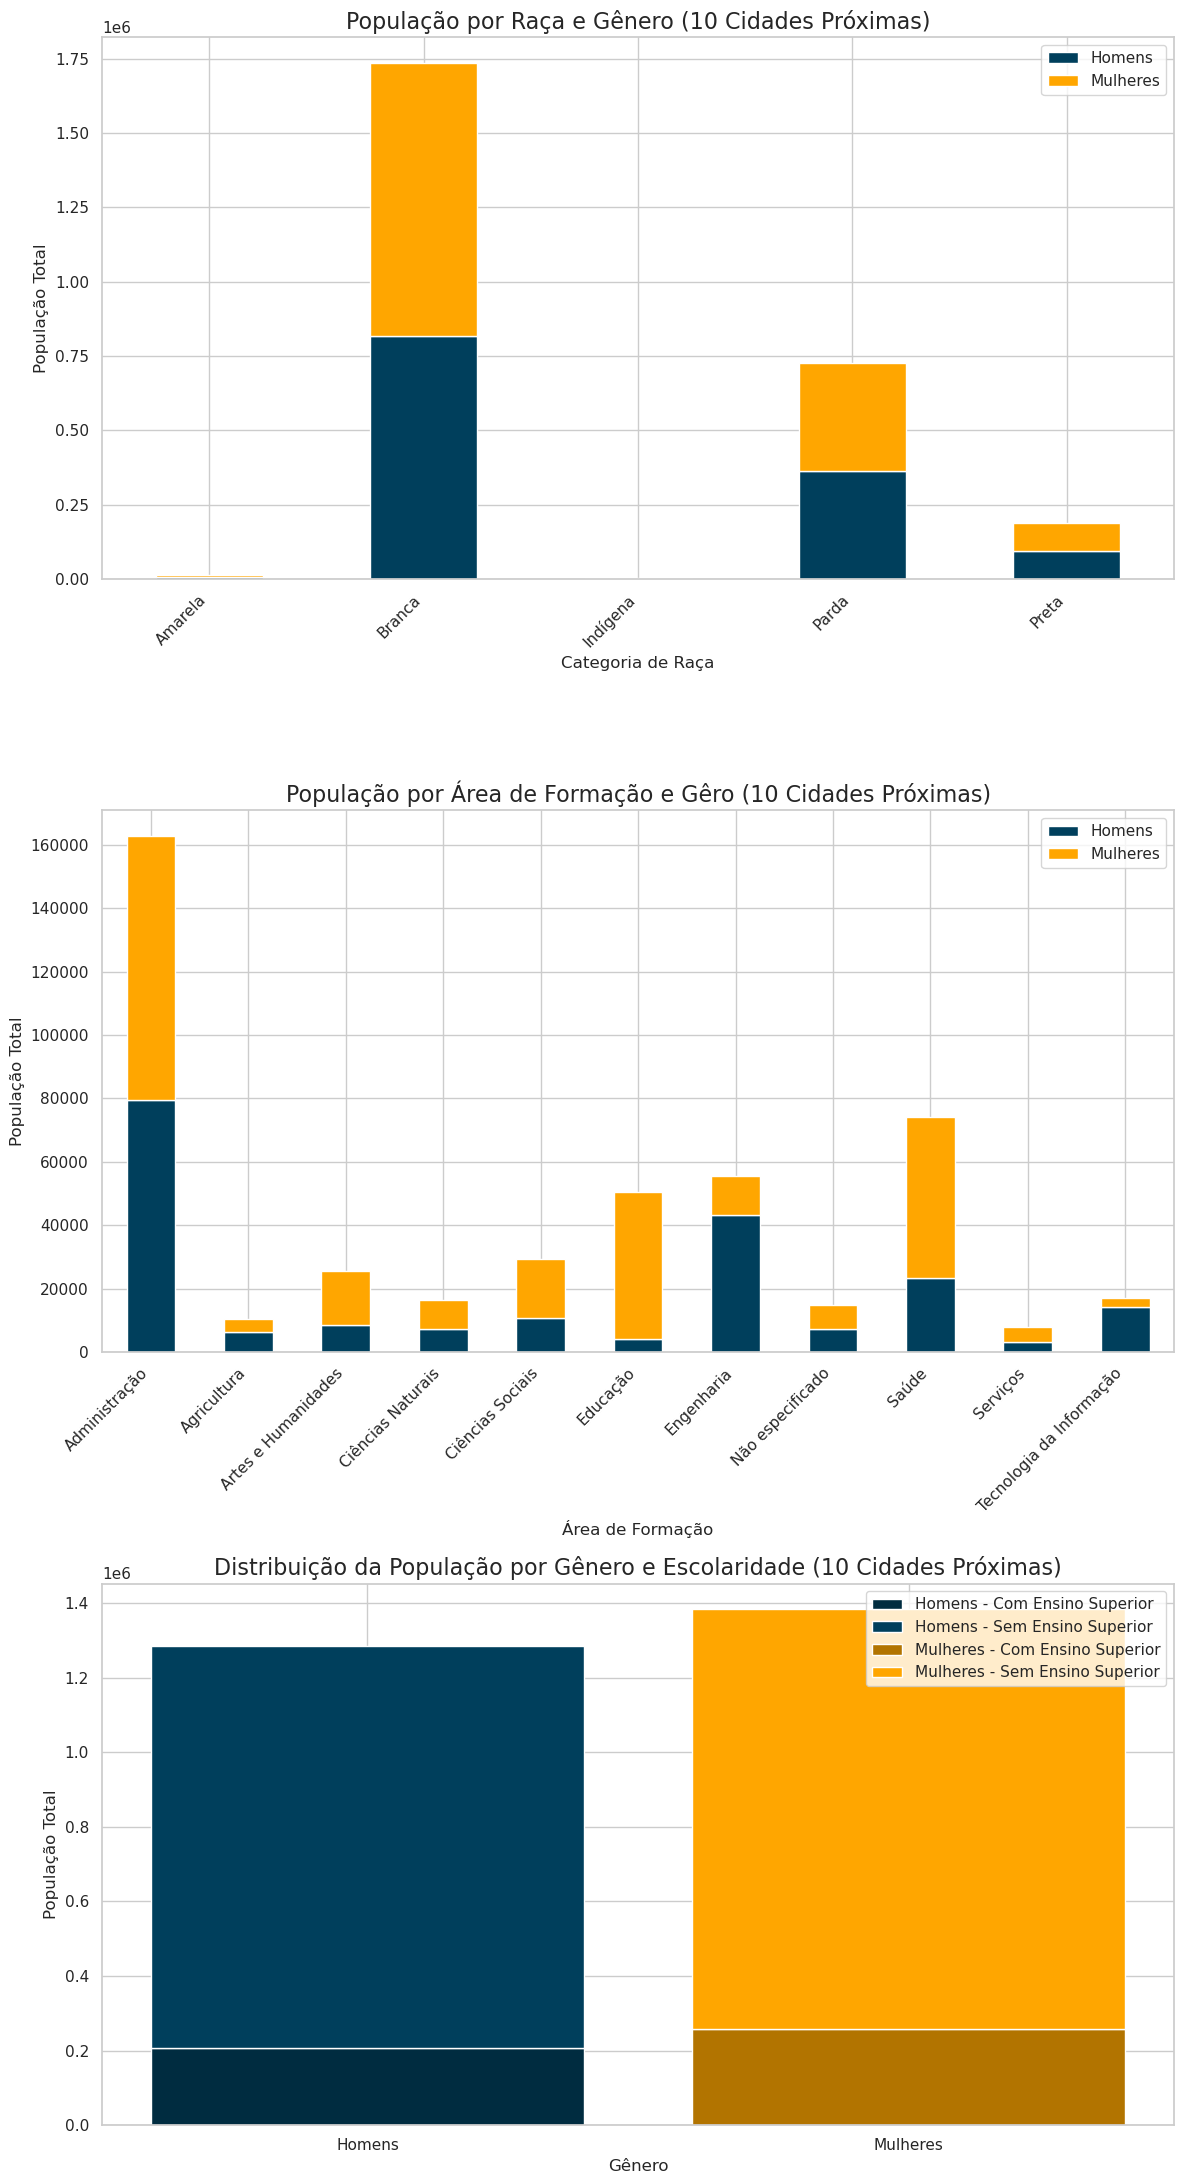

2025-09-25 09:40:51,573 INFO sqlalchemy.engine.Engine ROLLBACK


In [20]:
with Session() as session:
    cities = find_nearby_cities(session, 'São Carlos', 'SP', 10, 'manhattan')
    plot_demographic_distributions(cities, 'pt')

2025-09-25 09:40:51,591 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-09-25 09:40:51,604 INFO sqlalchemy.engine.Engine SELECT cities.id, cities.name, cities.is_capital, cities.ddd, cities.population, cities.timezone_name, cities.region_id, cities.state_id, cities.longitude, cities.latitude, cities.urban, cities.rural 
FROM cities JOIN (SELECT concat(CAST(cities.region_id AS VARCHAR), CAST(cities.state_id AS VARCHAR), CAST(cities.id AS VARCHAR)) AS id, cities.longitude AS lon, cities.latitude AS lat 
FROM cities JOIN states ON states.region_id = cities.region_id AND states.id = cities.state_id 
WHERE cities.name = %(name_1)s AND states.uf = %(uf_1)s 
 LIMIT %(param_1)s) AS target_city ON %(param_2)s 
WHERE coalesce((SELECT sum(coalesce(CAST(race_elements.value ->> %(value_1)s AS INTEGER), %(coalesce_1)s) + coalesce(CAST(race_elements.value ->> %(value_2)s AS INTEGER), %(coalesce_2)s)) AS sum_1 
FROM jsonb_each((cities.population -> %(population_1)s)) AS race_elements), %(coalesce_

,City,UF,Total Population
0,Araraquara,SP,"242,214"
1,Rio Claro,SP,"201,402"
2,Araras,SP,"130,859"
3,Jaú,SP,"133,485"
4,Limeira,SP,"291,863"
5,Piracicaba,SP,"423,312"
6,Ribeirão Preto,SP,"698,594"
7,Santa Bárbara d'Oeste,SP,"183,345"
8,Sertãozinho,SP,"126,883"
9,Americana,SP,"237,228"


Generating demographic plots...


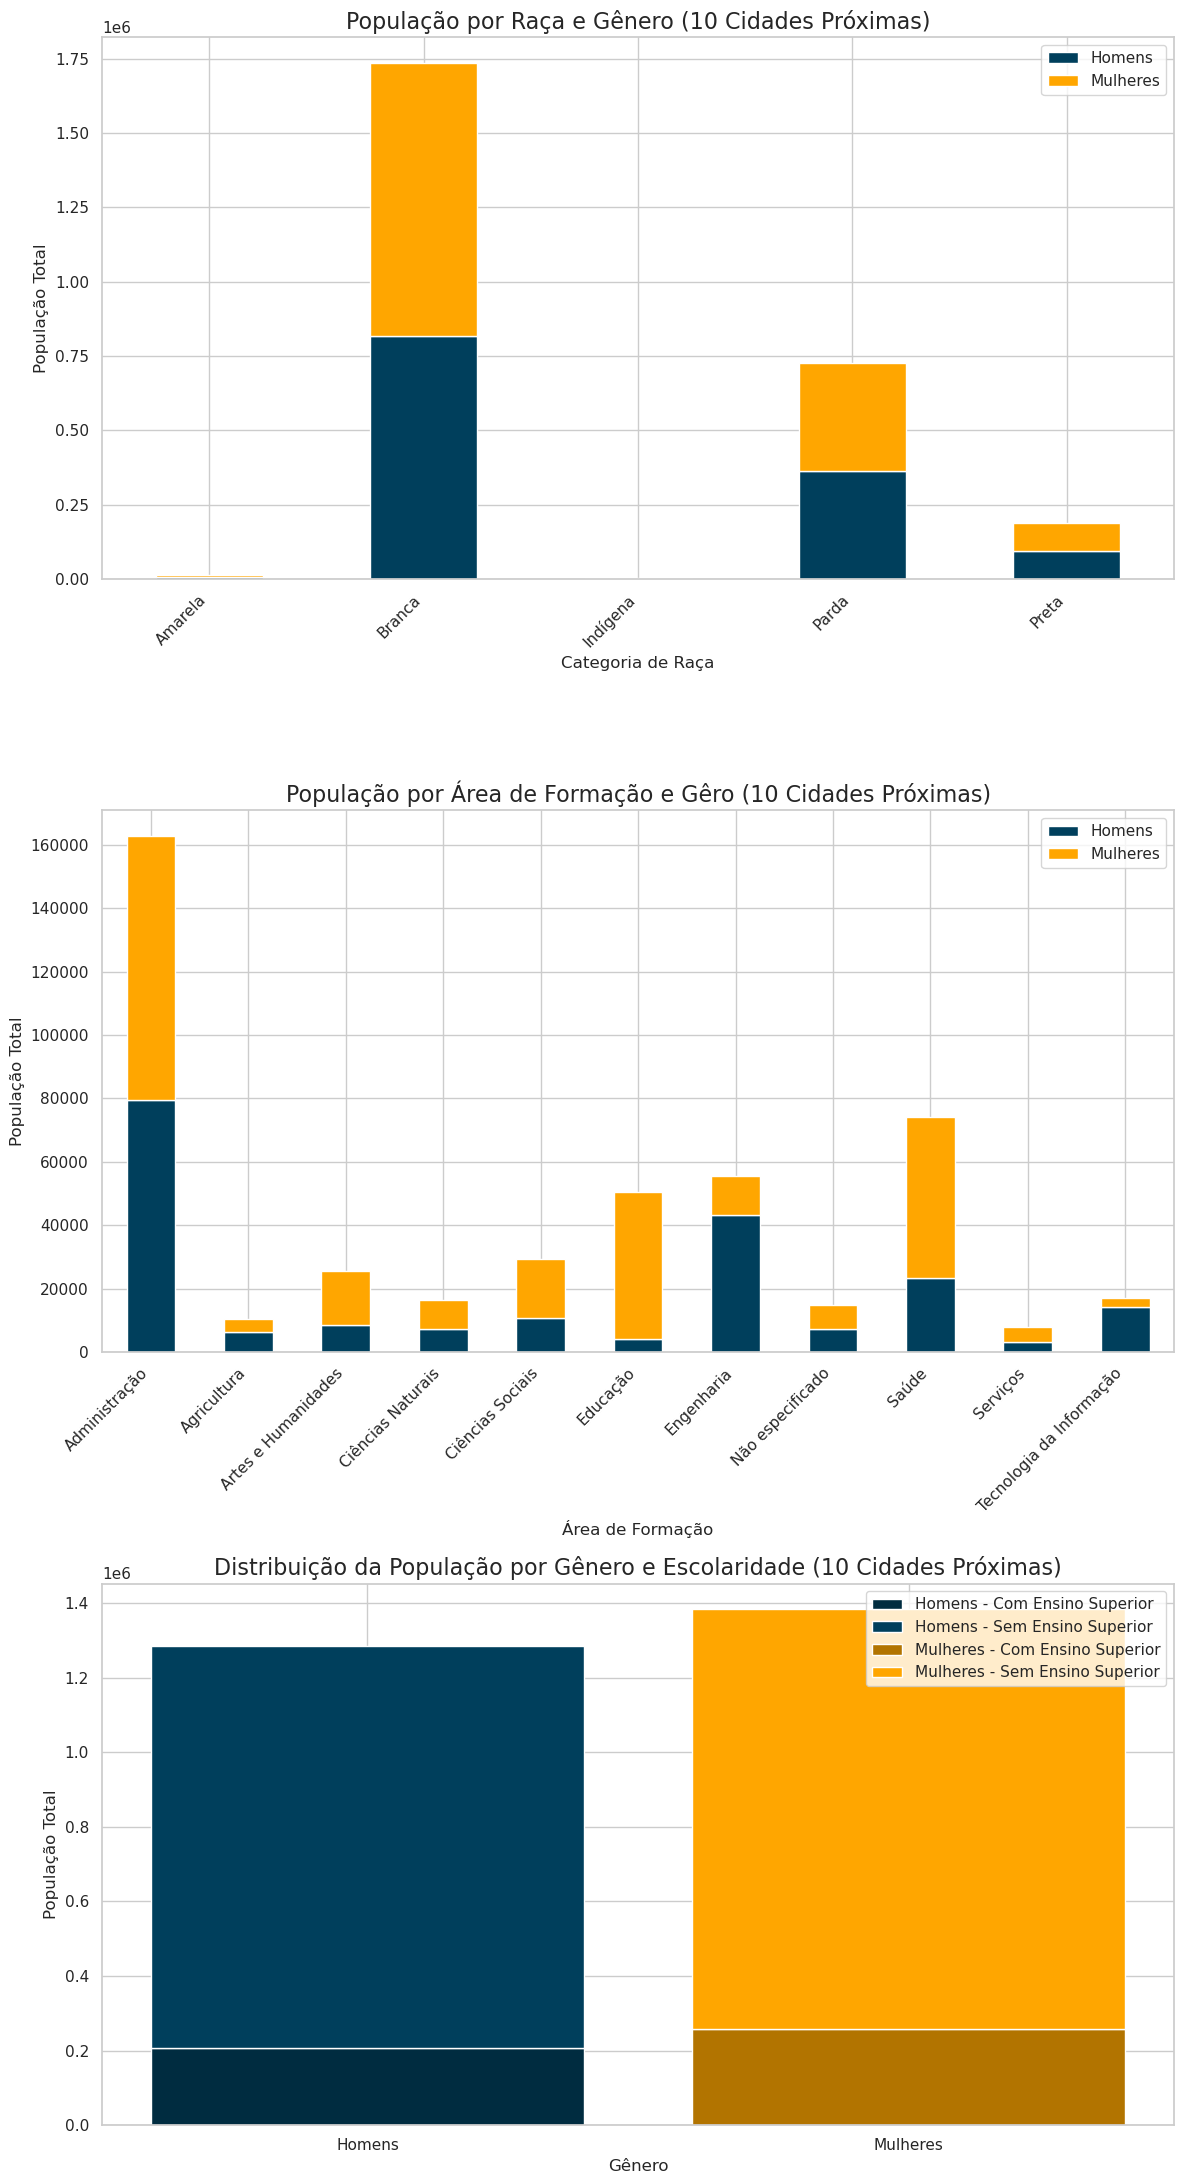

2025-09-25 09:40:52,659 INFO sqlalchemy.engine.Engine ROLLBACK


In [21]:
with Session() as session:
    cities = find_nearby_cities(session, 'São Carlos', 'SP', 10, 'euclidean')
    plot_demographic_distributions(cities, 'pt')